# Lab 2: Clustering

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 9, 2019. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

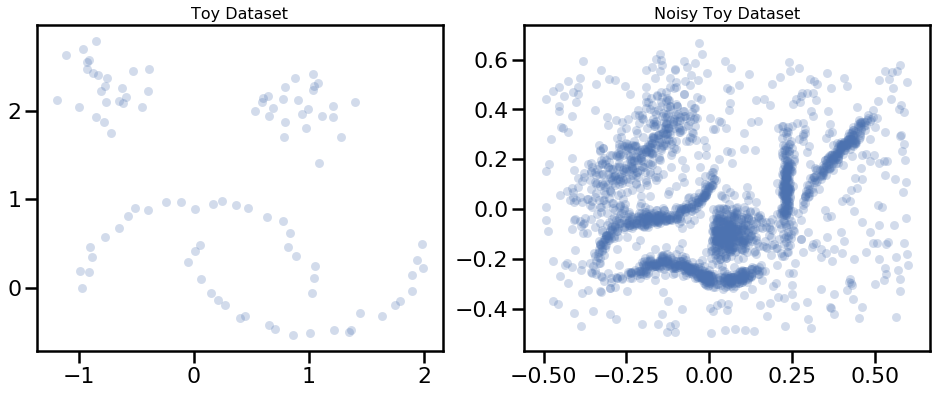

In [2]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

In [6]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

NameError: name 'test_data_0' is not defined

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [4]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse.csgraph import minimum_spanning_tree

In [5]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram

In [6]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # if it's not precomputed compute the distance matrix
        # using from scipy.spatial import distance 
        
        # HINT:
        # You can use a minimum spanning tree and add merge in increasing order
        # or modifying the distance matrix 
        # (add row/column for new clusters and remove/put zero in old row/colums)
        
        # keep track of merges in linkage_matrix_ and labels in hierarchy_
        
        # update labels_ from the hierarchy level selected by n_clusters_ 
        
        # Initializing attributes
        linkage_matrix_ = []
        labels_ = np.array(list(range(X.shape[0])))
        hierarchy_ =[labels_]
        
        # Computing distance matrix
        if self.metric_ == "precomputed":
            dist_matrix = X
        elif self.metric_ == "euclidean":
            dist_matrix = squareform(pdist(X))
        else:
            raise ValueError('Incorrect Metric.')
        
        # Computing Minimum Spanning Tree of Dataset
        min_span_tree = minimum_spanning_tree(dist_matrix).toarray().astype(float)
        
        # Iterating over minimum spanning tree to create clusters
        n = 0
        while np.unique(labels_).shape[0] > 1:
            # Find index of closest clusters
            i,j = np.where(min_span_tree==np.min(min_span_tree[np.nonzero(min_span_tree)]))
            # If multiple minimums, take the first one
            i,j = i[0],j[0]
            
            # Clusters i and j are merged together to form cluster X.shape[0]+n
            # Find points of clusters i and j
            merging_points = [l for l in range(labels_.shape[0]) if labels_[l] in [i,j]]
            # Update their label
            for l in merging_points:
                labels_[l] = X.shape[0]+n
            n += 1
            hierarchy_.append(np.copy(labels_))
            # Increment linkage matrix
            linkage_matrix_.append(np.array([i,j,min_span_tree[i,j],len(merging_points)]))
            
            # Columns and rows i and j of distance matrix are replaced with 0 and new column is added as the 
            # minimum of distances to each cluster from i and j
            min_span_tree[i,j]=0
            col_i, col_j = min_span_tree[:,i], min_span_tree[:,j]
            row_i, row_j = min_span_tree[i,:], min_span_tree[j,:]
            dist_i = col_i + row_i
            dist_j = col_j + row_j
            # Distance from each point to the new cluster is the min from their distance to i and j if both
            # non-zero, else the maximum
            dist_cluster = np.array(dist_i*dist_j==0).astype(int)*np.maximum(dist_i,dist_j) + np.array(dist_i*dist_j).astype(int)*np.minimum(dist_i,dist_j)
            
            # Replacing columns and rows i and j by 0
            min_span_tree[i,:] = 0
            min_span_tree[j,:] = 0
            min_span_tree[:,i] = 0
            min_span_tree[:,j] = 0
            
            # Adding new column and row to the min_span_tree matrix
            dist_cluster = dist_cluster.reshape((dist_cluster.shape[0],1))
            min_span_tree = np.c_[min_span_tree,dist_cluster]
            min_span_tree = np.vstack([min_span_tree,np.zeros(min_span_tree.shape[1])])
            
        self.linkage_matrix_ = linkage_matrix_
        self.labels_ = hierarchy_[-self.n_clusters_]
        self.hierarchy_ = hierarchy_
            
        return self
            
        
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''
        plt.figure(figsize=(8,6))
        dendrogram(self.linkage_matrix_)
        plt.show()

Apply the method to our toy datasets

Let us apply this method on the first dataset.

In [7]:
# TODO
slag_0 = my_SingleLinkageAglomerativeClustering(n_clusters=4)
# slag_1 = my_SingleLinkageAglomerativeClustering(n_clusters=4)

In [8]:
slag_0.fit(test_data_0)

In [9]:
# slag_1.fit(test_data_1)

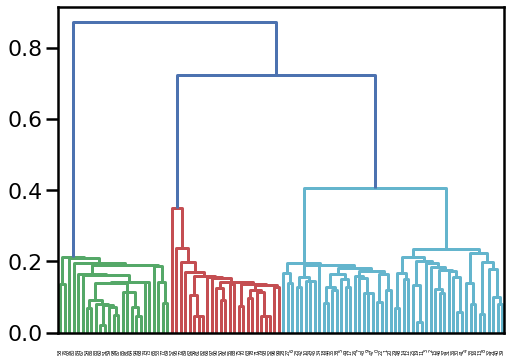

In [10]:
slag_0.plot_dendrogram()

In [11]:
# slag_1.plot_dendogram()

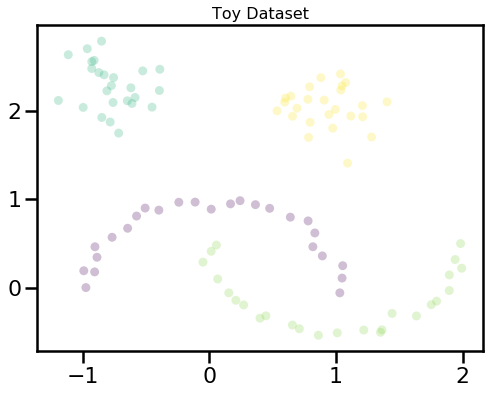

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(test_data_0.T[0], test_data_0.T[1], c=slag_0.labels_ , **plot_kwds)
ax.set_title('Toy Dataset', size=16)

plt.show();

Try the different linkage methods implemented in `sklearn`  and comment

Let us apply these methods on the noisy dataset.

In [13]:
# TODO
from sklearn.cluster import AgglomerativeClustering

In [14]:
ward_AC = AgglomerativeClustering(n_clusters=4,linkage='ward')
complete_AC = AgglomerativeClustering(n_clusters=4,linkage='complete')
average_AC = AgglomerativeClustering(n_clusters=4,linkage='average')
single_AC = AgglomerativeClustering(n_clusters=4,linkage='single')

In [15]:
ward_AC.fit(test_data_1)
complete_AC.fit(test_data_1)
average_AC.fit(test_data_1)
single_AC.fit(test_data_1)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='single', memory=None, n_clusters=4,
                        pooling_func='deprecated')

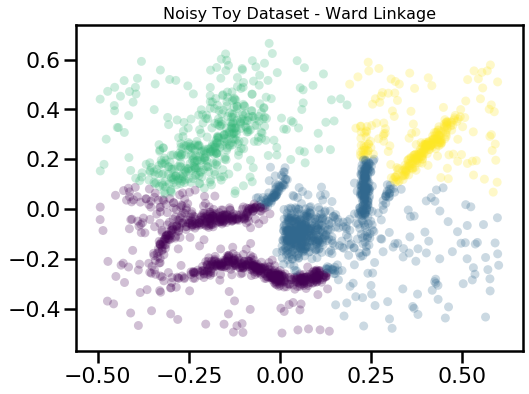

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(test_data_1.T[0], test_data_1.T[1], c=ward_AC.labels_ , **plot_kwds)
ax.set_title('Noisy Toy Dataset - Ward Linkage', size=16)

plt.show();

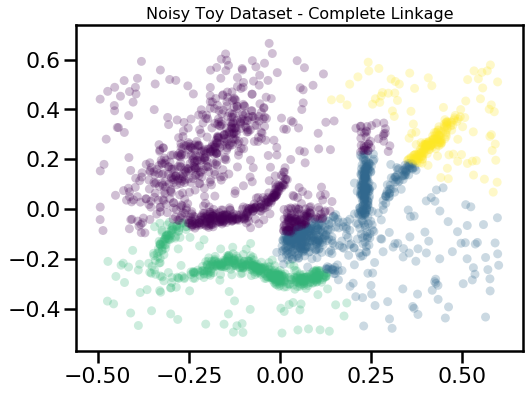

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(test_data_1.T[0], test_data_1.T[1], c=complete_AC.labels_ , **plot_kwds)
ax.set_title('Noisy Toy Dataset - Complete Linkage', size=16)

plt.show();

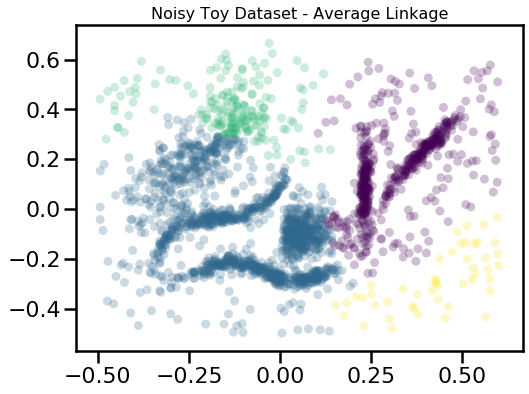

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(test_data_1.T[0], test_data_1.T[1], c=average_AC.labels_ , **plot_kwds)
ax.set_title('Noisy Toy Dataset - Average Linkage', size=16)

plt.show();

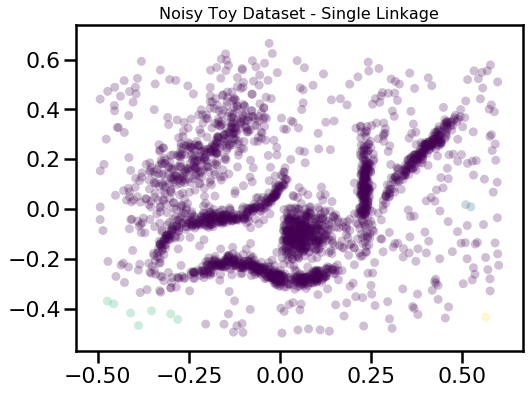

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(test_data_1.T[0], test_data_1.T[1], c=single_AC.labels_ , **plot_kwds)
ax.set_title('Noisy Toy Dataset - Single Linkage', size=16)

plt.show();

It is difficult to interpret these results as there is no obvious way to clusterize this dataset. On one hand, the  Single Linkage method has created one main cluster containing most of the dataset. On the other hand, the 3 left methods tried to find a balanced seperation of the space, offering 4 distinct clusters all containing an even amount of points. In this case,weI would probably choose the results from the Ward method as most satisfying because of its attempt to separate noise from high density zone.

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

In [20]:
# TODO
from sklearn.cluster import DBSCAN

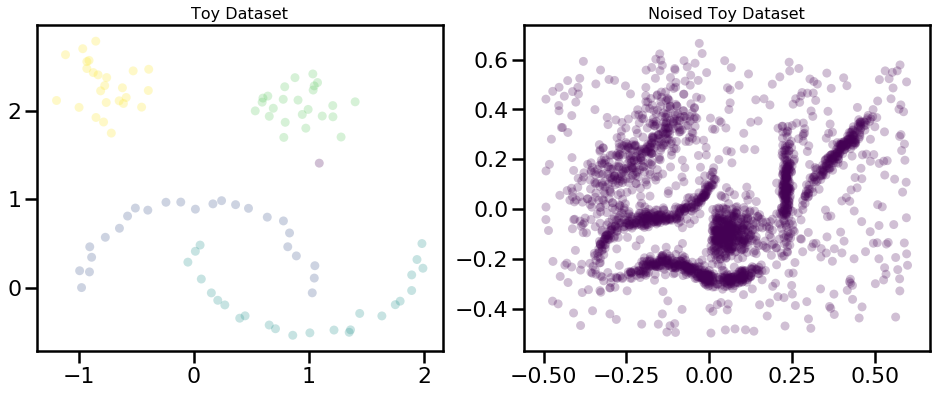

In [21]:
dbscan_0 = DBSCAN(eps=0.3, min_samples=2).fit(test_data_0)
dbscan_1 = DBSCAN().fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

As DBSCAN is a density based algorithm, the noisy dataset seems too dense in order to form separate clusters. Indeed, all points have an important neighbourhood which by union forms the entire dataset. \
In the case of the simple toy dataset, as each cluster is clearly separated and intra-cluster points are dense, we are able to deduct the natural clusters.

In order to tune parameters $\epsilon$ and $n_{min}$, we could fit multiple models using grid search (fit models for multiple values of hyper-parameters) and select the best model visually (although this method requires to evaluate models visually, thus work in small dimensions). \
Otherwise, it is possible to select $\epsilon$ and $n_{min}$ using the Elbow Trick:

In [22]:
from sklearn.neighbors import NearestNeighbors

In [23]:
mean_dist_0, mean_dist_1 = [],[]

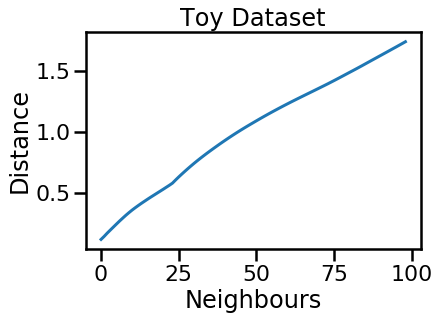

In [24]:
# Computing Elbow Trick on Toy Data

for i in range(2,test_data_0.shape[0]+1):
    nbrs = NearestNeighbors(n_neighbors=i).fit(test_data_0)
    distances,_ = nbrs.kneighbors(test_data_0)
    mean_dist_0.append(np.mean(distances[:,1:]))

plt.plot(mean_dist_0)
plt.title('Toy Dataset')
plt.xlabel('Neighbours')
plt.ylabel('Distance')
plt.show()

In [25]:
"""
# Computing Elbow Trick on Noisy Toy Data

for i in range(2,1001):
    nbrs = NearestNeighbors(n_neighbors=i).fit(test_data_1)
    distances,_ = nbrs.kneighbors(test_data_1)
    mean_dist_1.append(np.mean(distances[:,1:]))
    
plt.plot(mean_dist_1)
plt.title('Noised Toy Dataset')
plt.xlabel('Neighbours')
plt.ylabel('Distance')
plt.show()
"""

"\n# Computing Elbow Trick on Noisy Toy Data\n\nfor i in range(2,1001):\n    nbrs = NearestNeighbors(n_neighbors=i).fit(test_data_1)\n    distances,_ = nbrs.kneighbors(test_data_1)\n    mean_dist_1.append(np.mean(distances[:,1:]))\n    \nplt.plot(mean_dist_1)\nplt.title('Noised Toy Dataset')\nplt.xlabel('Neighbours')\nplt.ylabel('Distance')\nplt.show()\n"

Unfortunately, in this case, the Elbow Trick offers no clear 'arm shape' enabling us to decide on the correct values of $\epsilon$ and $n_{min}$.

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

In [26]:
# import hdbscan
# Error with the import ...

# TODO

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


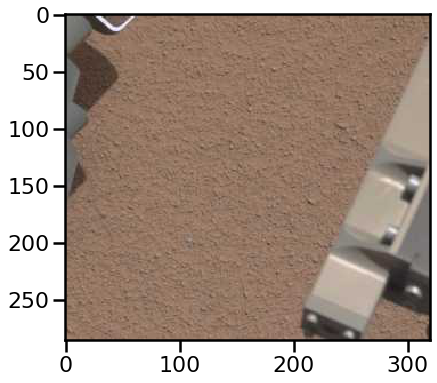

In [27]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [28]:
type(Im_1)

PIL.JpegImagePlugin.JpegImageFile

In [29]:
R,G,B = Im_1.split()
# Normalizing the images
R_arr, G_arr, B_arr = np.array(R)/255, np.array(G)/255, np.array(B)/255

In [30]:
# TODO:
# Computing I and S
I = (R_arr + G_arr + B_arr)/3
S = 1 - I * np.minimum(R_arr,G_arr,B_arr)

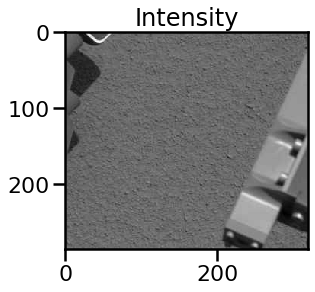

In [31]:
plt.title('Intensity')
plt.imshow(I, cmap='gray')
plt.show()

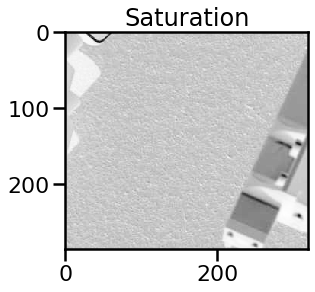

In [32]:
plt.title('Saturation')
plt.imshow(S, cmap='gray')
plt.show()

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

In [33]:
# TODO
I.shape, S.shape

((286, 320), (286, 320))

In [34]:
I_flat = np.ndarray.flatten(I)

In [35]:
S_flat = np.ndarray.flatten(S)

In [36]:
I_flat.shape, 286*320

((91520,), 91520)

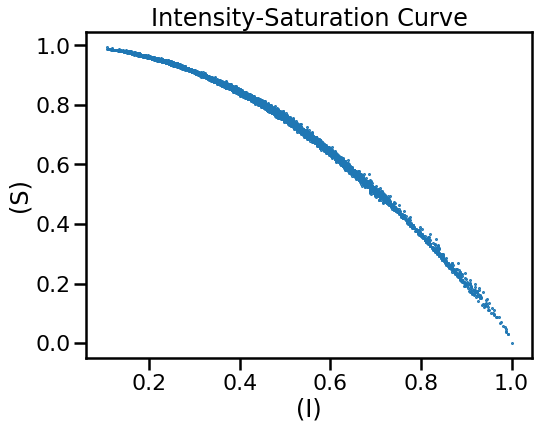

In [37]:
plt.figure(figsize=(8,6))
plt.scatter(I_flat,S_flat,s=1)
plt.xlabel('(I)')
plt.ylabel('(S)')
plt.title('Intensity-Saturation Curve')
plt.show()

In [38]:
data = np.hstack((I_flat.reshape((91520,1)),S_flat.reshape((91520,1))))

In [39]:
data.shape

(91520, 2)

##### 1) K-Means

In [40]:
kmeans_3 = KMeans(n_clusters=3,max_iter=200).fit(data)
kmeans_4 = KMeans(n_clusters=4,max_iter=200).fit(data)

In [41]:
labels_3 = kmeans_3.labels_
labels_4 = kmeans_4.labels_
# Image Representation of the decomposition
labels_im_3 = labels_3.reshape((286,320))
labels_im_4 = labels_4.reshape((286,320))

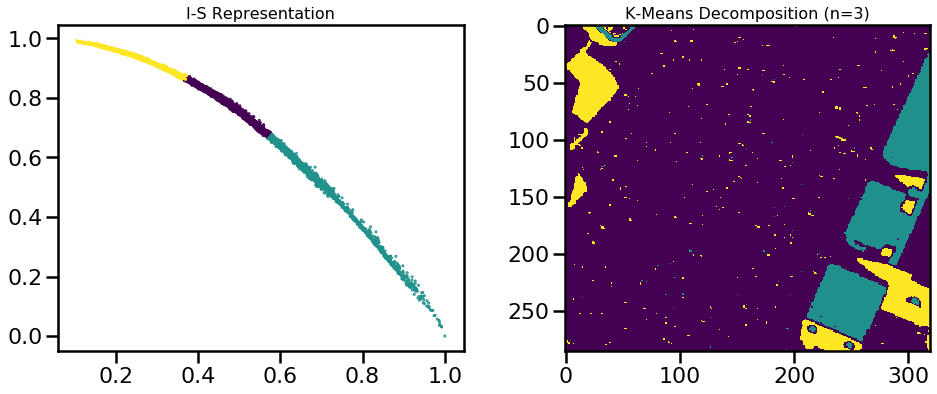

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(data[:,0],data[:,1],s=1,c=labels_3)
ax[0].set_title('I-S Representation', size=16)

ax[1].imshow(labels_im_3)
ax[1].set_title('K-Means Decomposition (n=3)', size=16)


plt.show();

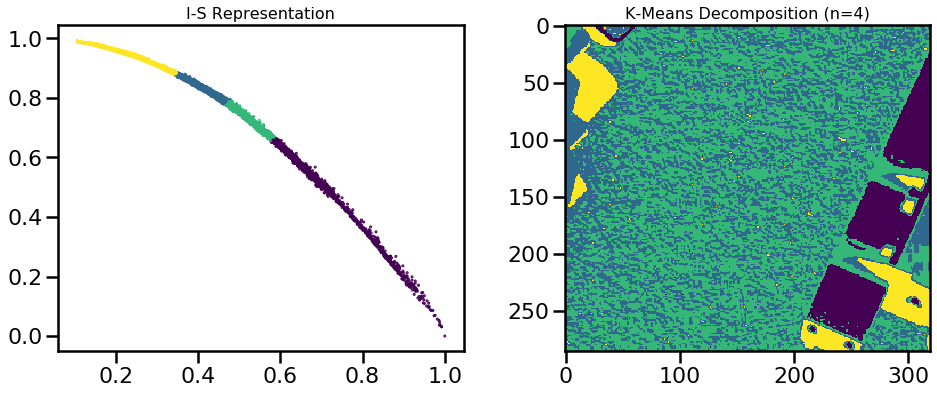

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(data[:,0],data[:,1],s=1,c=labels_4)
ax[0].set_title('I-S Representation', size=16)

ax[1].imshow(labels_im_4)
ax[1].set_title('K-Means Decomposition (n=4)', size=16)


plt.show();

The k-means offers satisfying results when it comes to segmenting the image. Indeed, it is able to clearly highlight the metal structure on the bottom right and the shadows from the background. Unfortunately, the piece on the top left is mixed with the background even when computing 4 clusters. \
Using 4 clusters in this case seems unnecessary. Indeed, it mostly separates the background cluster from n=3 into two seperate ones.

##### 2) Aglomerative Clustering

Ces algorithmes étant plus complexes en temps que les autres, il nous faut downsamplé l'image afin de faire terminer l'algo. Downsamplons l'image en moyennant des blocs de pixels de taille (2,2).

In [58]:
from skimage.measure import block_reduce

In [59]:
I_dwn = block_reduce(I,block_size=(2,2),func=np.mean)

In [60]:
S_dwn = block_reduce(S,block_size=(2,2),func=np.mean)

In [71]:
I_dwn.shape

(143, 160)

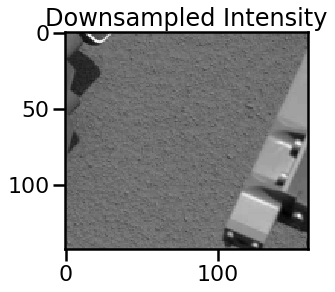

In [68]:
plt.title('Downsampled Intensity')
plt.imshow(I_dwn, cmap='gray')
plt.show()

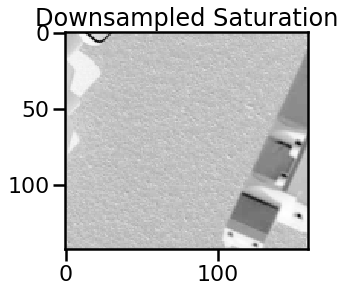

In [69]:
plt.title('Downsampled Saturation')
plt.imshow(S_dwn, cmap='gray')
plt.show()

In [61]:
I_flat_dwn = np.ndarray.flatten(I_dwn)

In [63]:
S_flat_dwn = np.ndarray.flatten(S_dwn)

In [64]:
I_flat_dwn.shape

(22880,)

In [65]:
data_dwn = np.hstack((I_flat_dwn.reshape((22880,1)),S_flat_dwn.reshape((22880,1))))

##### a. Single Linkage

In [78]:
single_AC = AgglomerativeClustering(n_clusters=3,linkage='single').fit(data_dwn)

In [79]:
labels = single_AC.labels_
# Image Representation of the decomposition
labels_im = labels.reshape((143,160))

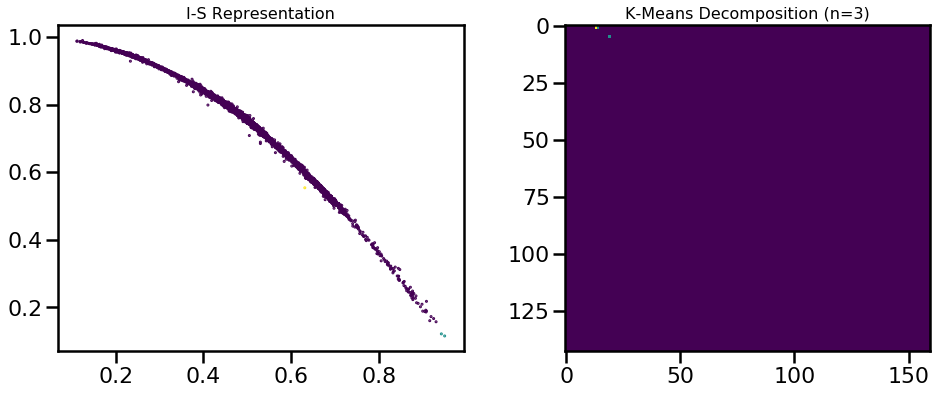

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(data_dwn[:,0],data_dwn[:,1],s=1,c=labels)
ax[0].set_title('I-S Representation', size=16)

ax[1].imshow(labels_im)
ax[1].set_title('K-Means Decomposition (n=3)', size=16)


plt.show();

##### b) Average Linkage

In [82]:
average_AC = AgglomerativeClustering(n_clusters=3,linkage='average').fit(data_dwn)

In [84]:
labels = average_AC.labels_
# Image Representation of the decomposition
labels_im = labels.reshape((143,160))

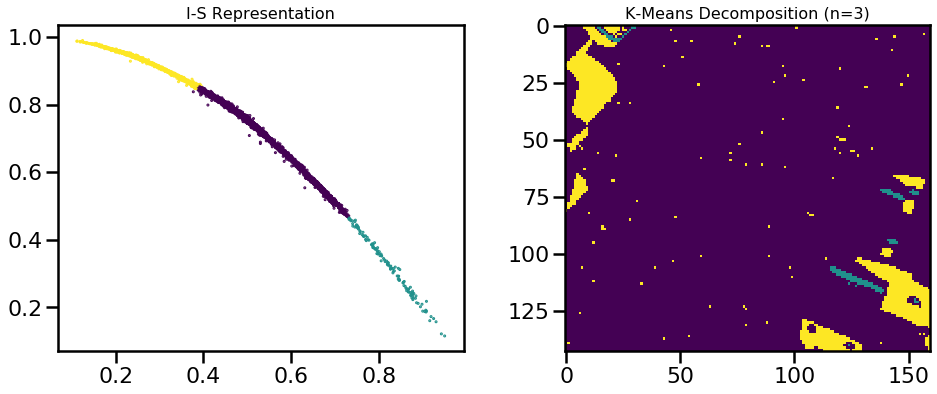

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(data_dwn[:,0],data_dwn[:,1],s=1,c=labels)
ax[0].set_title('I-S Representation', size=16)

ax[1].imshow(labels_im)
ax[1].set_title('K-Means Decomposition (n=3)', size=16)


plt.show();

##### c) Ward Linkage

In [86]:
ward_AC = AgglomerativeClustering(n_clusters=3,linkage='ward').fit(data_dwn)

In [87]:
labels = ward_AC.labels_
# Image Representation of the decomposition
labels_im = labels.reshape((143,160))

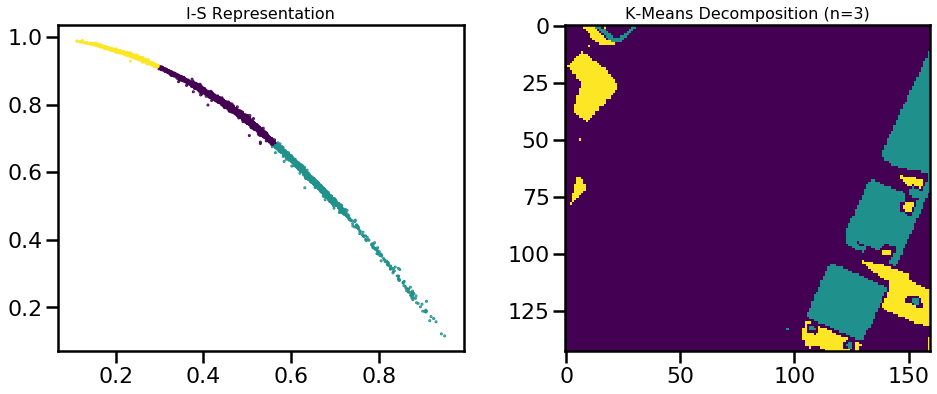

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(data_dwn[:,0],data_dwn[:,1],s=1,c=labels)
ax[0].set_title('I-S Representation', size=16)

ax[1].imshow(labels_im)
ax[1].set_title('K-Means Decomposition (n=3)', size=16)


plt.show();

##### d) Complete Linkage

In [89]:
complete_AC = AgglomerativeClustering(n_clusters=3,linkage='complete').fit(data_dwn)

In [90]:
labels = complete_AC.labels_
# Image Representation of the decomposition
labels_im = labels.reshape((143,160))

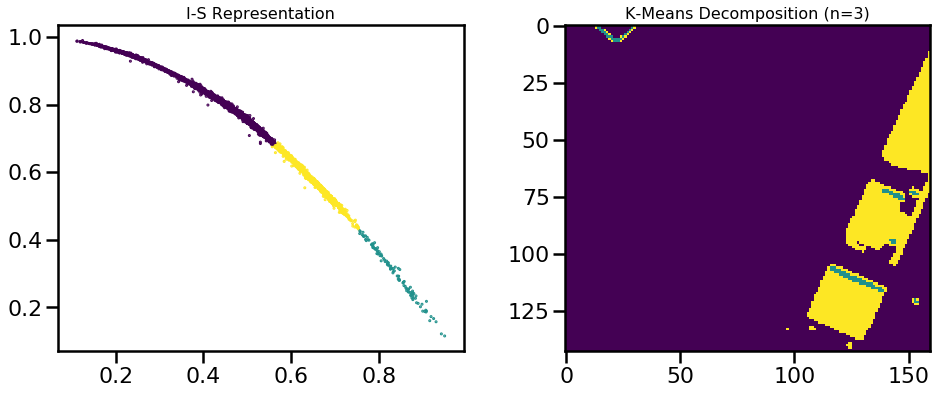

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(data_dwn[:,0],data_dwn[:,1],s=1,c=labels)
ax[0].set_title('I-S Representation', size=16)

ax[1].imshow(labels_im)
ax[1].set_title('K-Means Decomposition (n=3)', size=16)


plt.show();

The 4 methods offer quite different results. \
Indeed, the single linkage method is quite poor as two of the three clusters are reduces to a couple of points.\
The average linkage method also offers quite poor results. It does try to segment the bottom right metal structure but does it quite poorly. \
The complete linkage method offers satisfying results for the segmentation of the bottom right structure. Although it isn't perfect. Otherwise, it is unable to identify the top left part of the image and considers it as background. \
Finally, the ward method offers great results. Indeed, it is able to segment the bottom right structure almost perfectly and identifies part of the top left piece as well. It seems to be the best algorithm tested yet.

##### 3) DBSCAN

In [45]:
dbscan = DBSCAN(eps=0.1).fit(data)

In [50]:
np.unique(dbscan.labels_)

array([0])

Le DBSCAN ne permet d'obtenir qu'un seul cluster du dataset et ne mérite pas d'être tuné plus que cela. En effet, le DBSCAN extrait les zones denses du dataset. Or, dans le plan I-S, le dataset est représenté par une unique zone dense avec aucune séparation claire entre zones. Ainsi, si nous le tunons afin qu'il nous obtienne plusieurs clusters, ceux-ci n'auront pas un grand sens.

##### 4) HDBSCAN

In [51]:
# TODO

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

/Users/yopa/anaconda3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/yopa/anaconda3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


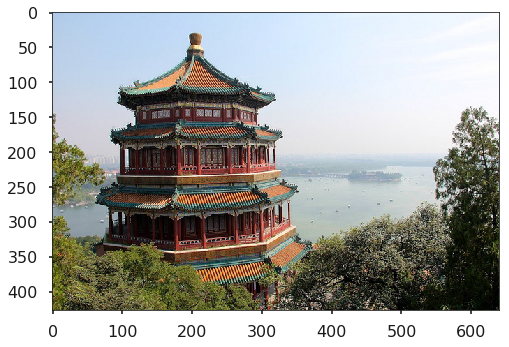

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

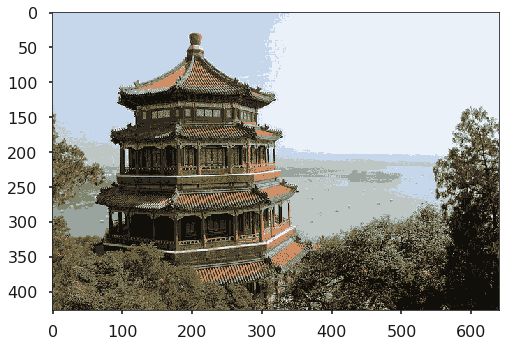

In [7]:
# TODO

# Stack the columns of our data array
stacked_data = china[:,0,:]
for j in range(1, np.shape(china)[1]):
    stacked_data = np.vstack((stacked_data, china[:,j,:]))
    
# Run K-means
kmeans = KMeans(n_clusters=10, max_iter=200).fit(stacked_data)

# Associate each data point to its cluster center
stacked_compressed_data = np.empty(shape=np.shape(stacked_data), dtype='object')

for i in range(np.shape(stacked_data)[0]):
    centroid_label = kmeans.labels_[i]
    centroid_coordinates = kmeans.cluster_centers_[centroid_label]
    
    stacked_compressed_data[i, :] = np.floor(centroid_coordinates)
    
# Unstack the compressed data
unstacked_compressed_data = np.vsplit(stacked_compressed_data, np.shape(china)[1])
unstacked_compressed_data = np.array(unstacked_compressed_data)

# Reform the coorect data shape by transposing the matrix
china_compressed = np.empty(shape=np.shape(china), dtype='object')

for i in range(np.shape(unstacked_compressed_data)[0]):
    for j in range(np.shape(unstacked_compressed_data)[1]):
        china_compressed[j,i,:] = unstacked_compressed_data[i,j,:]

# Plot compressed image
china_compressed = china_compressed.astype(np.uint8)

fig = plt.figure(figsize=(8, 6))
plt.imshow(china_compressed);

